I want to use this notebook how $b$ and $\tau_a$ change the traveling waves to identify, which ranges make the most sense. I do this for two different adaptation-dataframes: Once with $\mu_a=0=\mu_{e,i},\ \beta_a=5=\beta_{e,i}$. I start with $b=0.25,\ \tau_a=600$. For these, I identify parameterizations for which we have bistability without adaptation and 

(i) Bistability with adaptation, static Turing-instability in down with p_random=1, p_down=4 $\\ $
(ii) Bistability with adaptation, no Turing-instability with p_random=1, p_down=4 $\to$ "boundary effect"? $\\ $
(iii) Monostability with adaptation, p_random=p_down=4 $\\ $
(iv) Multistability with adaptation, p_random=1, p_down=4 $\\ $

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm

import py.continuum1d as continuum1d

from py.analysis import computeFPs, checkFixPtsStability

from py.funcs import getAvgPSD, getPSD
from py.params import setParams

In [2]:
#these settings are for resolution: 101x101; csv: high_default, adaps_101x101; \mu_a=0, \beta_a=5.
dic = {'(i)': [[0.42, -0.1], [0.88, 0.22]], 
       '(ii)': [[0.4, -0.08], [0.86, 0.22]], 
       '(iii)': [[0.24, -0.22], [0.18, -0.26]], 
       '(iv)': [[0.26, -0.2], [0.36, -0.12]]}
cases = pd.DataFrame(data=dic)
cases

,(i),(ii),(iii),(iv)
0,"[0.42, -0.1]","[0.4, -0.08]","[0.24, -0.22]","[0.26, -0.2]"
1,"[0.88, 0.22]","[0.86, 0.22]","[0.18, -0.26]","[0.36, -0.12]"


In [2]:
#these settings are for resolution: 201x201; csv: high_default, high-adaps; \mu_a=0.4, \beta_a=10.
dic = {'(i)': [[0.47, 0.01], [0.72, 0.16]], 
       '(ii)': [[0.4, -0.14], [0.86, 0.27]], 
       '(iii)': [[0.2, -0.25], [0.38, -0.04]], 
       '(iv)': [[0.39, -0.04], [None, None]]}
cases = pd.DataFrame(data=dic)
cases

,(i),(ii),(iii),(iv)
0,"[0.47, 0.01]","[0.4, -0.14]","[0.2, -0.25]","[0.39, -0.04]"
1,"[0.72, 0.16]","[0.86, 0.27]","[0.38, -0.04]","[None, None]"


In [3]:
c1d = continuum1d.continuum1d()

1d Model initialised.


In [80]:
ee, ii = np.array(cases.values[0,3])[0], np.array(cases.values[0,3])[1]
ee, ii

(0.26, -0.2)

In [81]:
tauas = np.linspace(0, 6000,21)
tau_zeros = np.zeros(len(tauas))

array([  10.,  300.,  600.,  900., 1200., 1500., 1800., 2100., 2400.,
       2700., 3000., 3300., 3600., 3900., 4200., 4500., 4800., 5100.,
       5400., 5700., 6000.])

In [4]:
def runCollection(item, item_str, ee, ii):
    
    params = {'I_e': ee, 'I_i': ii, 'end_t': 60*1000, 'mu_a': 0.4, 'beta_a': 10, 'b': 0.25, 'tau_a': 600}
    
    params = setParams(params)
    
    params[item_str] = item
    
    fps = computeFPs(params)
    stab = checkFixPtsStability(fps, params)
    
    exc, inh = c1d.run(params, itype='inte_adaptation', fp = fps[0])
    
    duration = 20
    
    exc_test = exc.T[60,-int(duration*1000*(1/params.dt)):]
    
    frequs, PSD = getPSD(exc_test, int(1000*(1/params.dt)), nperseg=duration)

    dom_frequ = frequs[np.argmax(PSD)] 
    
    e = exc_test
    up_steps = sum(x>=0.4 for x in e)
    down_steps = sum(x<0.4 for x in e)
    if dom_frequ==0:
        avg_steps_in_down = 0
        avg_steps_in_up = 0
    else:
        avg_steps_in_down = down_steps/(duration*dom_frequ)
        avg_steps_in_up = up_steps/(duration*dom_frequ)
    
    avg_up = avg_steps_in_up*params.dt*(1/1000) #in [s]
    avg_down = avg_steps_in_down*params.dt*(1/1000)
    
    return dom_frequ, avg_up, avg_down

In [7]:
names = ['i', 'ii', 'iii', 'iv']

tauas = np.linspace(0, 6000,21)
tauas[0] = 10
tau_zeros = np.zeros(len(tauas))

for l in range(4):
    ee, ii = np.array(cases.values[0,l])[0], np.array(cases.values[0,l])[1]

    d = {'tau_a': tauas, 'dom_frequ': tau_zeros, 'down_duration': tau_zeros, 'up_duration': tau_zeros}
    tau_df = pd.DataFrame(data=d)
    item_str = 'tau_a'

    for idx, item in enumerate(tauas):
        tau_df.values[idx, 1], tau_df.values[idx, 2], tau_df.values[idx, 3] = runCollection(item, item_str, ee, ii)
        
    tau_df.to_csv('csv/%s_tau_a_df.csv' %names[l])

In [8]:
names = ['i', 'ii', 'iii', 'iv']

bs = np.linspace(0, 0.5, 21)
b_zeros = np.zeros(len(bs))

for l in range(4):
    ee, ii = np.array(cases.values[0,l])[0], np.array(cases.values[0,l])[1]

    d = {'b': bs, 'dom_frequ': b_zeros, 'down_duration': b_zeros, 'up_duration': b_zeros}
    b_df = pd.DataFrame(data=d)
    item_str = 'b'

    for idx, item in enumerate(bs):
        b_df.values[idx, 1], b_df.values[idx, 2], b_df.values[idx, 3] = runCollection(item, item_str, ee, ii)
        
    b_df.to_csv('csv/%s_b_df.csv' %names[l])

/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-params.beta_i*(x-params.mu_i)))
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:25: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-params.beta_e*(x-params.mu_e)))
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:32: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-params.beta_a*(x-params.mu_a)))


In [ ]:
#collect dominant frequency, up-, and down-state duration for increasing tau_a

d = {'tau_a': tauas, 'dom_frequ': tau_zeros, 'down_duration': tau_zeros, 'up_duration': tau_zeros}
tau_df = pd.DataFrame(data=d)

for idx, tau_a in enumerate(tauas):
    
    params = {'I_e': ee, 'I_i': ii, 'end_t': 60*1000, 'mu_a': 0, 'beta_a': 5, 'b': 0.25, 'tau_a': tau_a}
    
    params = setParams(params)
    
    fps = computeFPs(params)
    stab = checkFixPtsStability(fps, params)
    
    exc, inh = c1d.run(params, itype='inte_adaptation', fp = fps[0])
    
    duration = 20
    
    exc_test = exc.T[60,-int(duration*1000*(1/params.dt)):]
    
    frequs, PSD = getPSD(exc_test, int(1000*(1/params.dt)), nperseg=duration)

    dom_frequ = frequs[np.argmax(PSD)] 
    
#    plt.figure(figsize=(12,4))
    
#    plt.plot(np.linspace(0,1,10000), exc.T[60,-10000:])#, vmin=0, vmax=1, aspect='auto')
#    plt.title('tau_a=%i' %int(tau_a))
#    plt.show()
      
#    plt.figure(figsize=(3,3))
#    plt.plot(frequs, PSD)
#    plt.show()
    
    e = exc_test
    up_steps = sum(x>=0.4 for x in e)
    down_steps = sum(x<0.4 for x in e)
    if dom_frequ==0:
        avg_steps_in_down = 0
        avg_steps_in_up = 0
    else:
        avg_steps_in_down = down_steps/(duration*dom_frequ)
        avg_steps_in_up = up_steps/(duration*dom_frequ)
    
    avg_up = avg_steps_in_up*params.dt*(1/1000) #in [s]
    avg_down = avg_steps_in_down*params.dt*(1/1000) #in [s]
    
    tau_df.values[idx, 1] = dom_frequ
    tau_df.values[idx, 2] = avg_down
    tau_df.values[idx, 3] = avg_up
    print(tau_df.values[idx,:])

In [83]:
tau_df

,tau_a,dom_frequ,down_duration,up_duration
0,10.0,0.00,0.000000,0.000000
1,300.0,2.25,0.244822,0.199622
2,600.0,1.60,0.348453,0.276547
3,900.0,1.30,0.428408,0.340823
4,1200.0,1.15,0.482000,0.387565
5,1500.0,1.00,0.558815,0.441185
6,1800.0,0.95,0.616389,0.436242
7,2100.0,0.85,0.658418,0.518053
8,2400.0,0.80,0.696400,0.553600
9,2700.0,0.75,0.732880,0.600453


In [84]:
tau_df.to_csv('csv/iv_tau_a_df_trial.csv')

In [85]:
bs = np.linspace(0, 0.5, 21)
b_zeros = np.zeros(len(bs))
bs

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  ])

In [86]:
#collect dominant frequency, up-, and down-state duration for increasing b

d = {'b': bs, 'dom_frequ': b_zeros, 'down_duration': b_zeros, 'up_duration': b_zeros}
b_df = pd.DataFrame(data=d)

for idx, b in enumerate(bs):
    
    params = {'I_e': ee, 'I_i': ii, 'end_t': 60*1000, 'mu_a': 0, 'beta_a': 5, 'b': b, 'tau_a': 600}
    
    params = setParams(params)
    
    fps = computeFPs(params)
    stab = checkFixPtsStability(fps, params)
    
    exc, inh = c1d.run(params, itype='inte_adaptation', fp = fps[0])
    
    duration = 20
    
    exc_test = exc.T[60,int(-duration*1000*(1/params.dt)):]
    
    frequs, PSD = getPSD(exc_test, int(1000*(1/params.dt)), nperseg=duration)

    dom_frequ = frequs[np.argmax(PSD)] 
    
    plt.figure(figsize=(12,4))
    
#    plt.plot(np.linspace(0,1,10000), exc.T[60,-10000:])#, vmin=0, vmax=1, aspect='auto')
#    plt.title('b=%.2f' %b)
#    plt.show()
      
#    plt.figure(figsize=(3,3))
#    plt.plot(frequs, PSD)
#    plt.show()
    
    
    e = exc_test
    up_steps = sum(x>=0.4 for x in e)
    down_steps = sum(x<0.4 for x in e)
    if dom_frequ==0:
        avg_steps_in_down = 0
        avg_steps_in_up = 0
    else:
        avg_steps_in_down = down_steps/(duration*dom_frequ)
        avg_steps_in_up = up_steps/(duration*dom_frequ)
    
    avg_up = avg_steps_in_up*params.dt*(1/1000) #in [s]
    avg_down = avg_steps_in_down*params.dt*(1/1000) #in [s]
    
    b_df.values[idx, 1] = dom_frequ
    b_df.values[idx, 2] = avg_down
    b_df.values[idx, 3] = avg_up
    
    print('iteration %i\%i done' %(idx, len(bs)))

iteration 0\21 done
iteration 1\21 done
iteration 2\21 done
iteration 3\21 done
iteration 4\21 done
iteration 5\21 done
iteration 6\21 done
iteration 7\21 done
iteration 8\21 done
iteration 9\21 done
iteration 10\21 done
iteration 11\21 done
iteration 12\21 done
iteration 13\21 done
iteration 14\21 done
iteration 15\21 done
iteration 16\21 done
iteration 17\21 done
iteration 18\21 done
iteration 19\21 done


/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1542/1697237952.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,4))


iteration 20\21 done


<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

In [87]:
b_df

,b,dom_frequ,down_duration,up_duration
0,0.000,0.05,0.000000,20.000000
1,0.025,0.45,1.056700,1.165522
2,0.050,0.70,0.732186,0.696386
3,0.075,0.85,0.605324,0.571147
4,0.100,1.00,0.488625,0.511375
5,0.125,1.15,0.468296,0.401270
6,0.150,1.20,0.427158,0.406175
7,0.175,1.35,0.388178,0.352563
8,0.200,1.40,0.385268,0.329018
9,0.225,1.50,0.360580,0.306087


In [88]:
b_df.to_csv('csv/iv_b_a_df_trial.csv')

In [89]:
bi = pd.read_csv('csv/b_a_df_trial.csv')
bii = pd.read_csv('csv/ii_b_a_df_trial.csv')
biii = pd.read_csv('csv/iii_b_a_df_trial.csv')
biv = pd.read_csv('csv/iv_b_a_df_trial.csv')

taui = pd.read_csv('csv/tau_a_df_trial.csv')
tauii = pd.read_csv('csv/ii_tau_a_df_trial.csv')
tauiii = pd.read_csv('csv/iii_tau_a_df_trial.csv')
tauiv = pd.read_csv('csv/iv_tau_a_df_trial.csv')

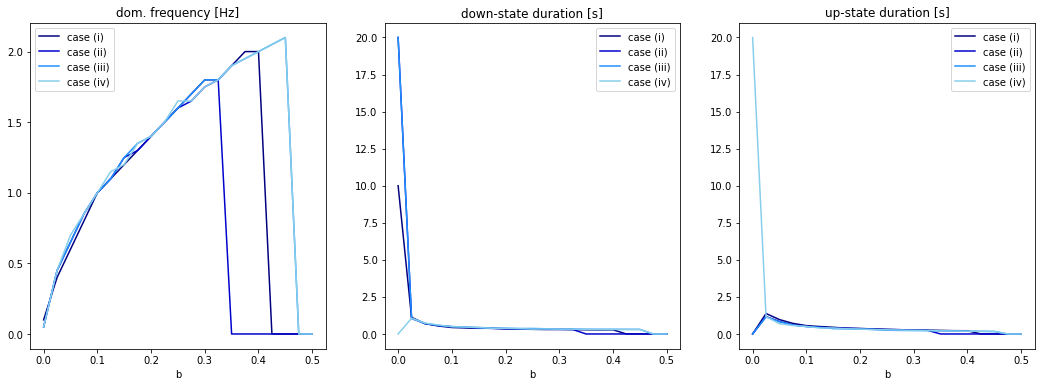

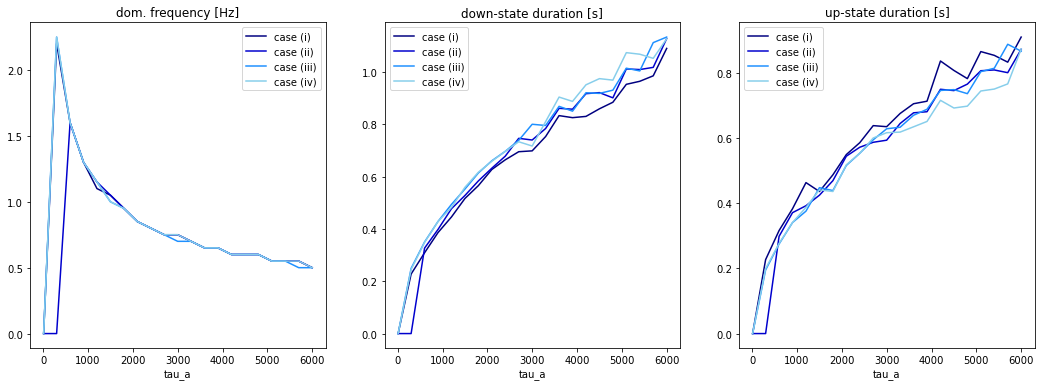

In [92]:
labels = ['(i)', '(ii)', '(iii)', '(iv)']
colors = ['navy', 'mediumblue', 'dodgerblue', 'skyblue'] #cm.get_cmap('winter', 4)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18,6))

ax0.set_title('dom. frequency [Hz]')
ax1.set_title('down-state duration [s]')
ax2.set_title('up-state duration [s]')

for idx, b_df in enumerate([bi, bii, biii, biv]):
    b_df.plot(ax=ax0, x='b',  y='dom_frequ', c=colors[idx],
              label='case %s' %labels[idx])
    
    b_df.plot(ax=ax1, x='b',  y='down_duration', c=colors[idx],
              label='case %s' %labels[idx])
    
    b_df.plot(ax=ax2, x='b',  y='up_duration', c=colors[idx],
              label='case %s' %labels[idx])
    
    
plt.show()
                                    
    
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18,6)) 

ax0.set_title('dom. frequency [Hz]')
ax1.set_title('down-state duration [s]')
ax2.set_title('up-state duration [s]')

for idx, tau_df in enumerate([taui, tauii, tauiii, tauiv]):
    tau_df.plot(ax=ax0, x='tau_a', y='dom_frequ', c=colors[idx],
                label='case %s' %labels[idx])
    
    tau_df.plot(ax=ax1, x='tau_a', y='down_duration', c=colors[idx],
                label='case %s' %labels[idx])
    
    tau_df.plot(ax=ax2, x='tau_a', y='up_duration', c=colors[idx],
                label='case %s' %labels[idx])

plt.show()

In [70]:
#b_df.plot(0, [1,2,3], figsize=(4, 12), subplots=True)
#tau_df.plot(0, [1,2,3], figsize=(4, 12), subplots=True)